<h1>Hole and Boundary Detection</h1>

In this particular notebook, we use the ground plane filtered dataset and detect the holes and boundaries for the vehicles. We do it in the following ways
1) Data Cleaning - Noise Elimination
2) Hole Detection - Delaunay Triangulation
3) Hole Detection  - Sensitivity Analysis
4) Boundary Detection - Convex Hulls

In [6]:
# Loading all the necessary libraries
import pdal
import numpy as np
import pandas as pd
import laspy
import open3d as o3d
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import statistics
import json
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [7]:
# Reading the previous CSF ground plane filtered file (".laz" format)
file_path = 'CSF_Filtering_Output.laz'  
lidar_data = laspy.read(file_path)

# Preparing the data extracting the coordinates
coords = np.vstack((lidar_data.x, lidar_data.y, lidar_data.z)).transpose()

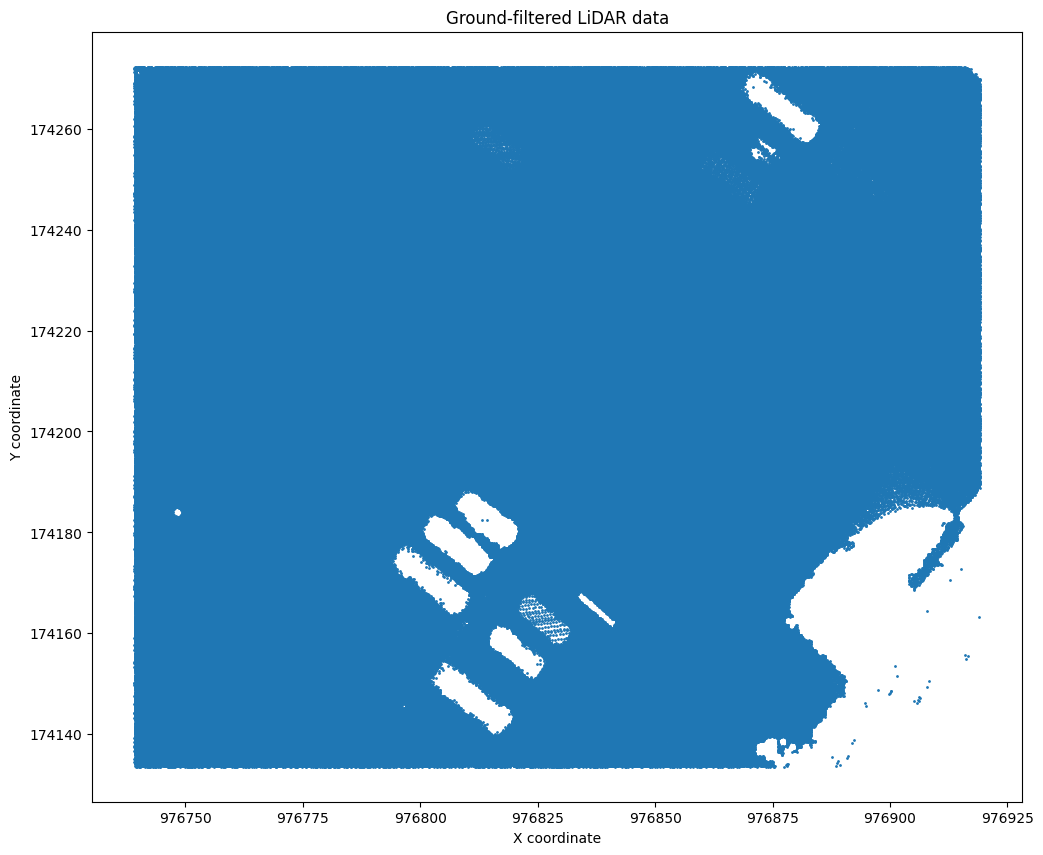

In [8]:
# Plotting the filtered coordinates 
plt.figure(figsize=(12, 10))
plt.scatter(coords[:, 0], coords[:, 1], s=1)  
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Ground-filtered LiDAR data')
plt.show()

<h3>1. Data Cleaning - Noise Elimination </h3> 

In this particular stage, we compute the mean and standard deviation of z coordinates of the filtered dataset. Further we eliminate points beyond 2 standard deviations indicating that they could most possibly be outliers. We then plot the data to observe the difference.

z_mean=8.504140004296662
z_std=0.6036658541744861


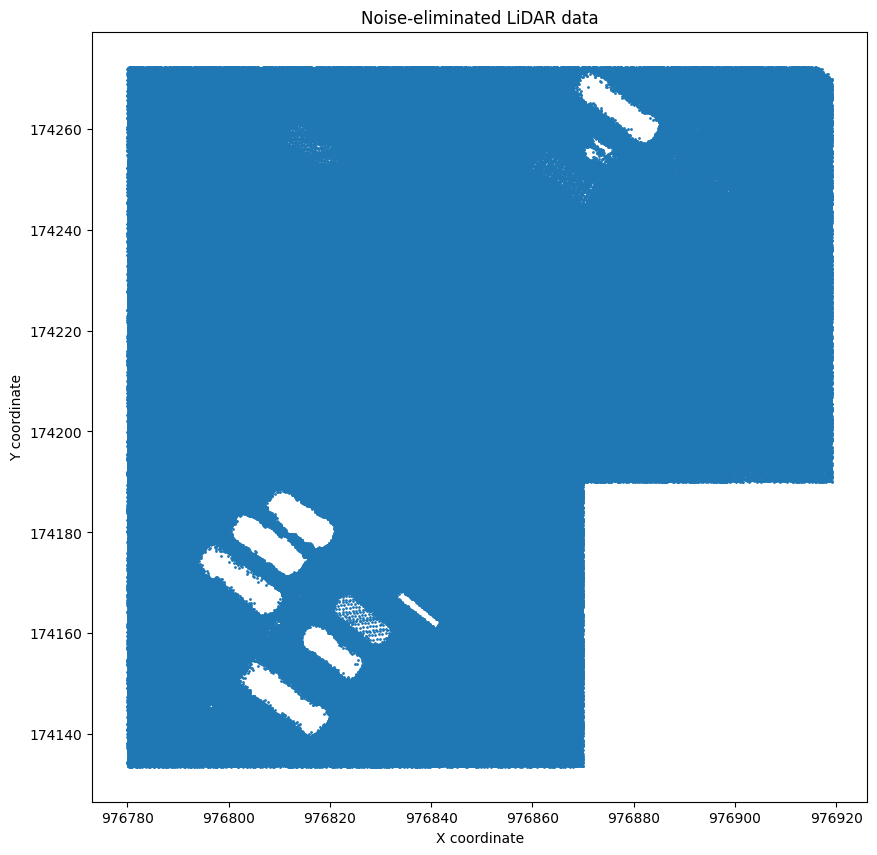

In [9]:
# Computing the mean and standard deviation of z coordinates
z_mean = np.mean(coords[:, 2])
z_std = np.std(coords[:, 2])
print(f"z_mean={z_mean}")
print(f"z_std={z_std}")

# Defining a threshold for Z values and considering within 2 standard deviations from the mean
threshold = 2

# Create a mask to filter out the points based on the threshold
mask = np.abs(coords[:, 2] - z_mean) < threshold * z_std
data_filtered = coords[mask]

# Region filtering: exclude points within a specified bounding box
# Define bounding box limits
x_limit_right  = 976870  
y_limit_bottom  = 174190  
x_limit_left=976780

# Create a mask to exclude points
mask_exclude_right = (data_filtered[:, 0] > x_limit_right) & (data_filtered[:, 1] < y_limit_bottom)
mask_exclude_left = (data_filtered[:, 0] < x_limit_left) 
mask = ~(mask_exclude_right | mask_exclude_left)
coords = data_filtered[mask]

# Plotting the noise-eliminated data
plt.figure(figsize=(10, 10))
plt.scatter(coords[:, 0], coords[:, 1], s=1)
plt.title("Noise-eliminated LiDAR data")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.show()


In [10]:
# Considering only x and y coordinates for further processing and analysis of holes
points_2d = coords[:, :2]

<h3> 2. Hole Detection - Delaunay Triangulation </h3>

To detect the holes, we leverage the concept of Delaunay triangulation and use the implementation from the ``` scipy.spatial ``` library. 

**Delaunay Triangulation** 
> It connects all the nodes in the form of mesh which we can leverage and use triangle properties to identify holes in the ground plane

In the below cells, we use 3 functions to detect holes.
1) ``` calculate_area() ``` : We calculate the area of the triangle formed by the connected nodes. We retrieve the nodes (vertices) using the simplices produced by the ``` delaunay ``` object.
2) ``` calculate_aspect_ratio() ``` : We calculate the aspect ratio of the longest side and the shortest side using the vertices of the triangle.
3) ``` detect_holes() ``` : We detect the holes by iteratively going through every simplice (triangle vertices) and check whether they meet certain threshold criteria in terms of area and aspect ratio

In [11]:
# Hole Detection

# Calculate the area of a triangle from its vertices
def calculate_area(v1, v2, v3):
    # Using Heron's formula
    a = np.linalg.norm(v2 - v1)
    b = np.linalg.norm(v3 - v2)
    c = np.linalg.norm(v1 - v3)
    s = (a + b + c) / 2
    area = s * (s - a) * (s - b) * (s - c)
    
    # Check if the area calculation is negative due to floating point inaccuracy
    if area < 0 and np.isclose(area, 0):
        area = 0
    return np.sqrt(area) if area >= 0 else 0

# Calculate the aspect ratio of a triangle from its vertices
def calculate_aspect_ratio(v1, v2, v3):
    edges = [np.linalg.norm(v2 - v1), np.linalg.norm(v3 - v2), np.linalg.norm(v1 - v3)]
    max_edge = max(edges)
    min_edge = min(edges)
    return max_edge / min_edge if min_edge > 0 else np.inf
    
# Detect holes by passing all the filtered points and respective thresholds.
def detect_holes(points_2d, threshold_area, max_area, aspect_ratio_threshold):
    tri = Delaunay(points_2d)
    hole_candidates = []
    aspect_ratios = []

    for t in tri.simplices:
        v1, v2, v3 = points_2d[t[0]], points_2d[t[1]], points_2d[t[2]]
        area = calculate_area(v1, v2, v3)
        aspect_ratio = calculate_aspect_ratio(v1, v2, v3)

        aspect_ratios.append(aspect_ratio)
        if threshold_area < area < max_area and aspect_ratio < aspect_ratio_threshold:
            hole_candidates.extend(t)

    #print(f"Max aspect ratios of all triangles: {max(aspect_ratios)}")
    #print(f"Mean aspect ratios of all triangles: {statistics.mean(aspect_ratios)}")
    return np.unique(hole_candidates), tri

<h3> 3. Hole Detection  - Sensitivity Analysis </h3>

To choose thresholds with more intent, we decided to perform **Sensitivity Analysis** to understand the distribution of the points and appropriately choose a threshold to detect the holes. To detect the holes, we calculate the average spacing between the nodes using ``` KDTree ``` library. We then initialize thresholds to multiples of average spacing ``` [2, 2.5, 3, 4, 5] ``` and run the above function to check the distribution of the points and accordingly choose the points. We use the optimal value for the threshold.

In the below cell,
1. ``` calculate_average_spacing() ``` : We compute the average spacing between all the nodes by using the *nearest_neighbor* concept from KDTrees. 

In [12]:
# Compute the average spacing between nodes
def calculate_average_spacing(points_2d):
    tree = KDTree(points_2d)
    distances, _ = tree.query(points_2d, k=2) 
    average_spacing = np.mean(distances[:, 1])  
    return average_spacing

average_spacing = calculate_average_spacing(points_2d)
print(f"average_spacing: {average_spacing}")


average_spacing: 0.07417840745472833


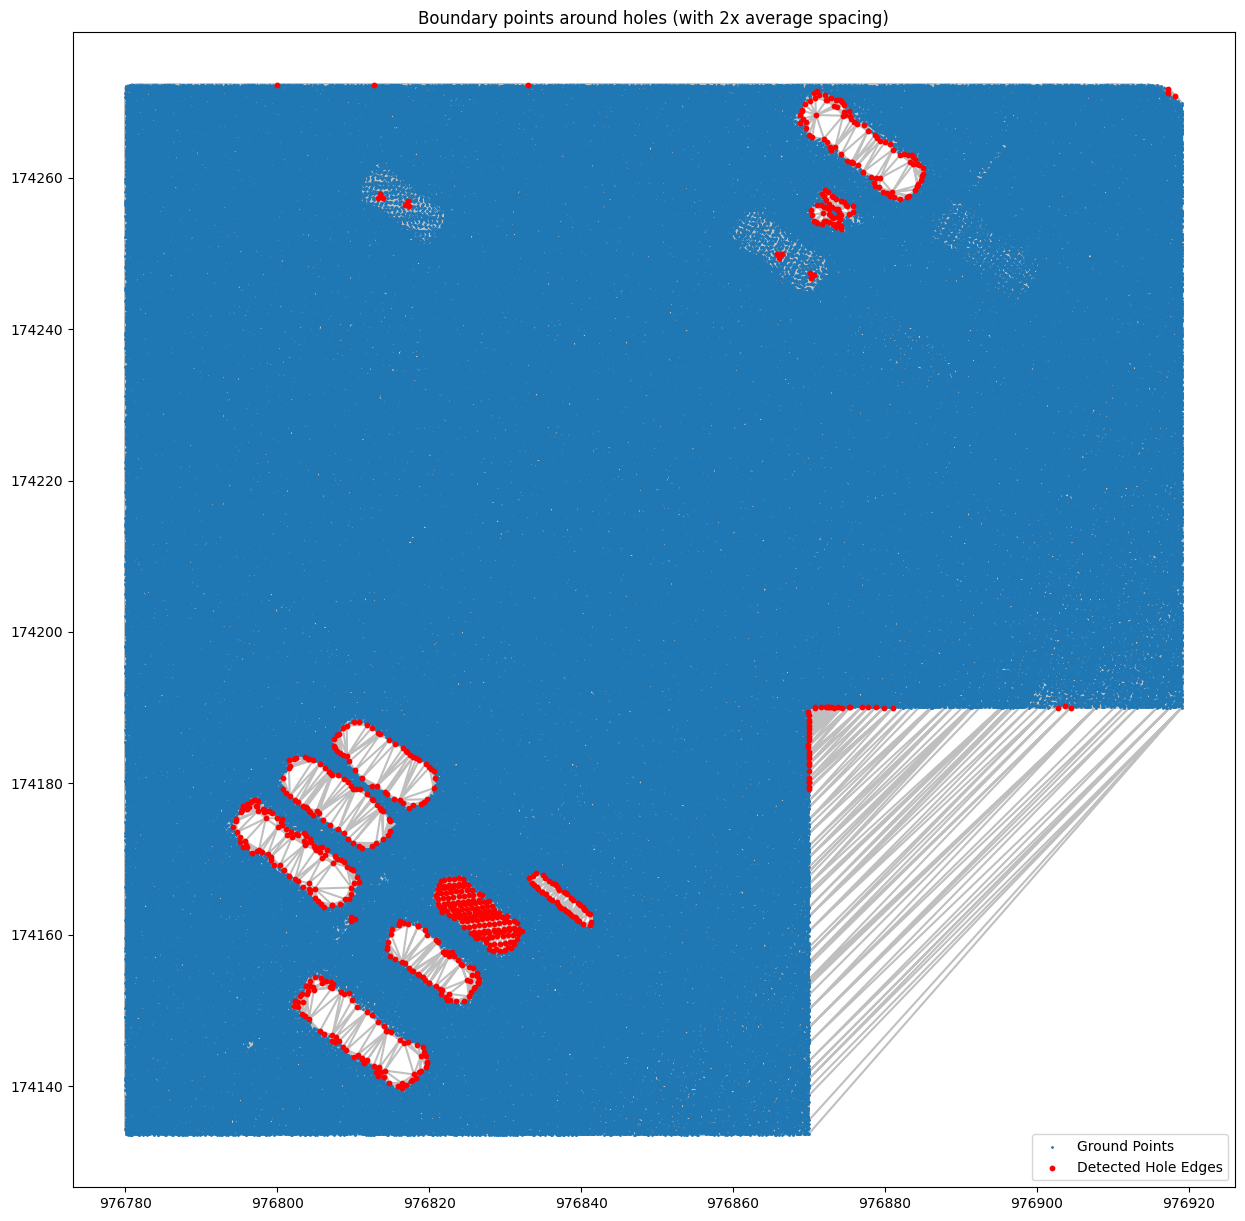

In [13]:
# defining the thresholds for further computations
aspect_ratio_threshold = 100
threshold_area = 2 * average_spacing
max_area = 60 * average_spacing
# Calling the detect_holes() function with the final thresholds
points_around_holes, triangulation = detect_holes(points_2d, threshold_area, max_area, aspect_ratio_threshold)
len(points_around_holes)
# Plotting with final thresholds
plt.figure(figsize=(15, 15))
plt.triplot(points_2d[:, 0], points_2d[:, 1], triangulation.simplices.copy(), color='gray', alpha=0.5)
plt.scatter(points_2d[:, 0], points_2d[:, 1], label='Ground Points', s=1)
plt.scatter(points_2d[points_around_holes, 0], points_2d[points_around_holes, 1], color='r', label='Detected Hole Edges', s=10)
plt.legend()
plt.title('Boundary points around holes (with 2x average spacing)')
plt.show()

<h3>4. Boundary Detection - alpha shape </h3>

In [14]:
boundary_points = points_2d[points_around_holes]

In [15]:
boundary_points

array([[976875.57, 174267.77],
       [976883.31, 174262.11],
       [976875.06, 174256.3 ],
       ...,
       [976884.  , 174258.44],
       [976884.37, 174259.14],
       [976884.72, 174259.77]])

We can see from the above graph the *local convex hulls* in red connecting the boundary points. This can further be improved and refined in the fiture.
All the other local convex hulls can be eliminated by using the shape properties of convex hulls defined earlier.

Try alpha shape

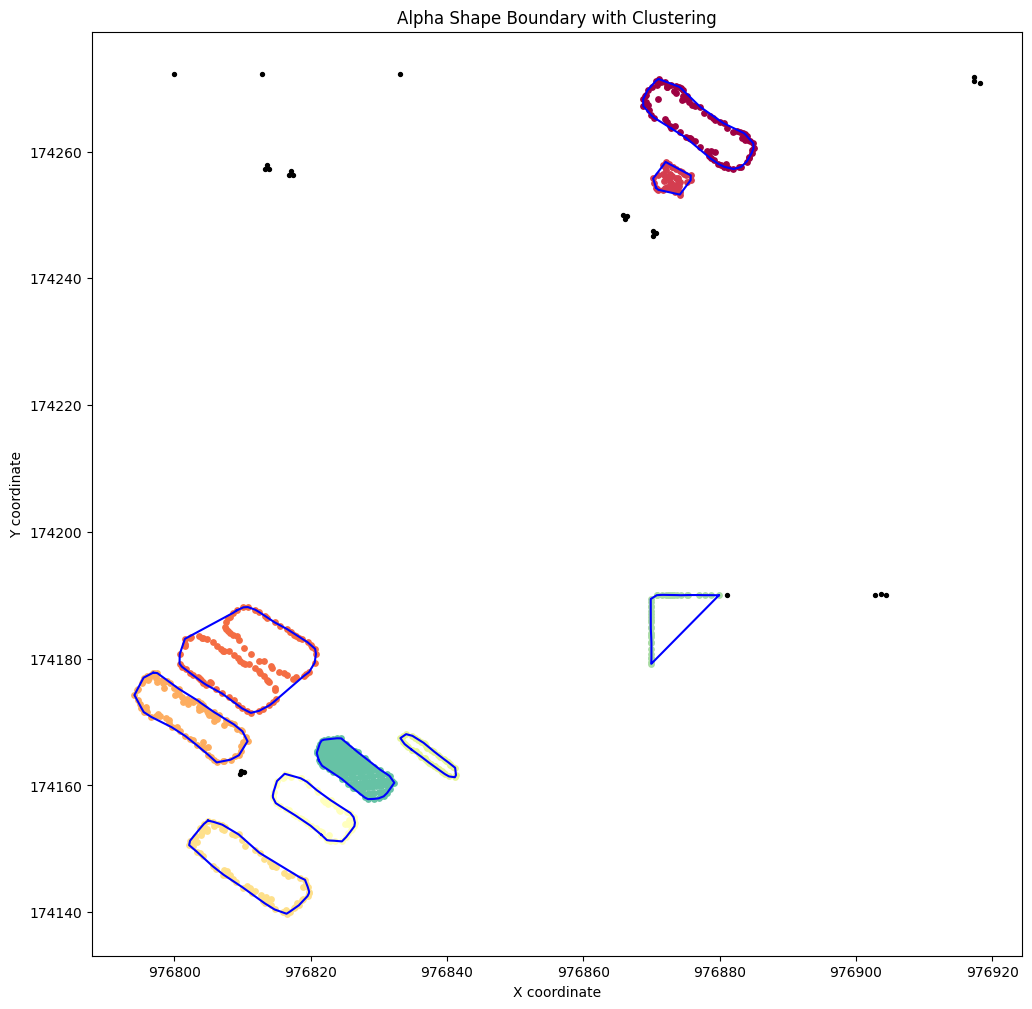

In [16]:
import alphashape
from sklearn.cluster import DBSCAN

# Apply DBSCAN clustering
eps = 2.06
min_samples = 4
clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(boundary_points)
labels = clustering.labels_

# Plot each cluster with its alpha shape
unique_labels = set(labels)
fig, ax = plt.subplots(figsize=(12,12))

for label in unique_labels:
    if label == -1:
        # Noise points
        color = 'k'
        size = 8
    else:
        color = plt.cm.Spectral(label / float(len(unique_labels)))
        size = 15

    class_member_mask = (labels == label)
    cluster_points = boundary_points[class_member_mask]

    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], color=color, s=size)

    if label != -1:
        alpha = 0.05  
        alpha_shape = alphashape.alphashape(cluster_points, alpha)
        if hasattr(alpha_shape, 'geoms'):
            for polygon in alpha_shape.geoms:
                x, y = polygon.exterior.xy
                ax.plot(x, y, color='red')
        else:
            x, y = alpha_shape.exterior.xy
            ax.plot(x, y, color='blue')


plt.title('Alpha Shape Boundary with Clustering')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.show()

In [17]:
alpha_shape.exterior.xy

(array('d', [976821.18, 976820.89, 976820.97, 976821.16, 976821.3300000001, 976821.59, 976821.9400000001, 976823.23, 976823.86, 976824.48, 976826.89, 976827.93, 976830.24, 976831.2000000001, 976831.5700000001, 976832.27, 976831.22, 976830.71, 976829.9500000001, 976829.3200000001, 976828.4, 976827.91, 976826.17, 976825.4400000001, 976824.59, 976821.73, 976821.64, 976821.36, 976821.18]),
 array('d', [174163.99, 174165.09, 174165.41, 174166.02, 174166.6, 174167.07, 174167.22, 174167.37, 174167.44, 174167.42, 174165.27, 174164.4, 174162.45, 174161.77, 174161.49, 174160.42, 174158.82, 174158.28, 174157.96, 174157.88, 174157.84, 174158.11000000002, 174159.59, 174160.23, 174161.0, 174163.06, 174163.15, 174163.64, 174163.99]))

In [96]:
def error_percentage(calculated_value, actual_value):
    return round((abs(calculated_value - actual_value)/actual_value)*100, 2)

def aspect_ratio(length, width):
    return length / width

def distance(a, b):
    return np.linalg.norm(a - b)

def removeNoise(polygon):
    coords = polygon.exterior.coords
    # Why does this condition exist?
    #if hasattr(alpha_shape, 'geoms'):
    #    coords = polygon.exterior.coords for polygon in alpha_shape.geoms]

    car_width = 5.3 # Calculate in Cloud compare and put an average value here.
    car_aspect_ratio = 1.6 # Calculate set of aspect ratios and finalize a constant or threshold for that
    
    npy_coords = np.array(coords)
    centroid = np.array([polygon.centroid.x, polygon.centroid.y])
    dist = []

    for i in range(len(coords)):
        dist.append(distance(npy_coords[i], centroid))

    halfWidth = min(dist)
    hyp = max(dist) # Ideally assuming this would be a hypotenuse of a rectangle

    width = 2 * halfWidth
    length = 2 * np.sqrt(hyp**2 - np.divide(hyp**2, 4))

    if (error_percentage(width, car_width) > 15):
        return False # Not a vehicle as the width is either too small or too big


    if (aspect_ratio(length, width) < car_aspect_ratio):
        return False # Most possibly not a vehicle as usually cars are long, unless there are some exceptions in which case would have to modify this condition
    
    
    area = length * width

    if (error_percentage(area, polygon.area) > 20):
        return False # As mostly not a rectangular surface!

    # The polygon or alphashape is most likely a vehicle.
    # Need to validate and check if more constraints can be added here.
    return True

In [97]:
# Apply DBSCAN clustering
eps = 2.06
min_samples = 4
clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(boundary_points)
labels = clustering.labels_

# Save alpha shapes
alpha_shapes = {}

unique_labels = set(labels)
for label in unique_labels:
    if label != -1:
        class_member_mask = (labels == label)
        cluster_points = boundary_points[class_member_mask]
        
        alpha = 0.05  
        alpha_shape = alphashape.alphashape(cluster_points, alpha)
        if (removeNoise(alpha_shape)):
            if hasattr(alpha_shape, 'geoms'):
                alpha_shapes[int(label)] = [list(polygon.exterior.coords) for polygon in alpha_shape.geoms]
            else:
                alpha_shapes[int(label)] = [list(alpha_shape.exterior.coords)]  

# Save alpha shapes to a JSON file
with open('alpha_shapes_new.json', 'w') as f:
    json.dump(alpha_shapes, f)

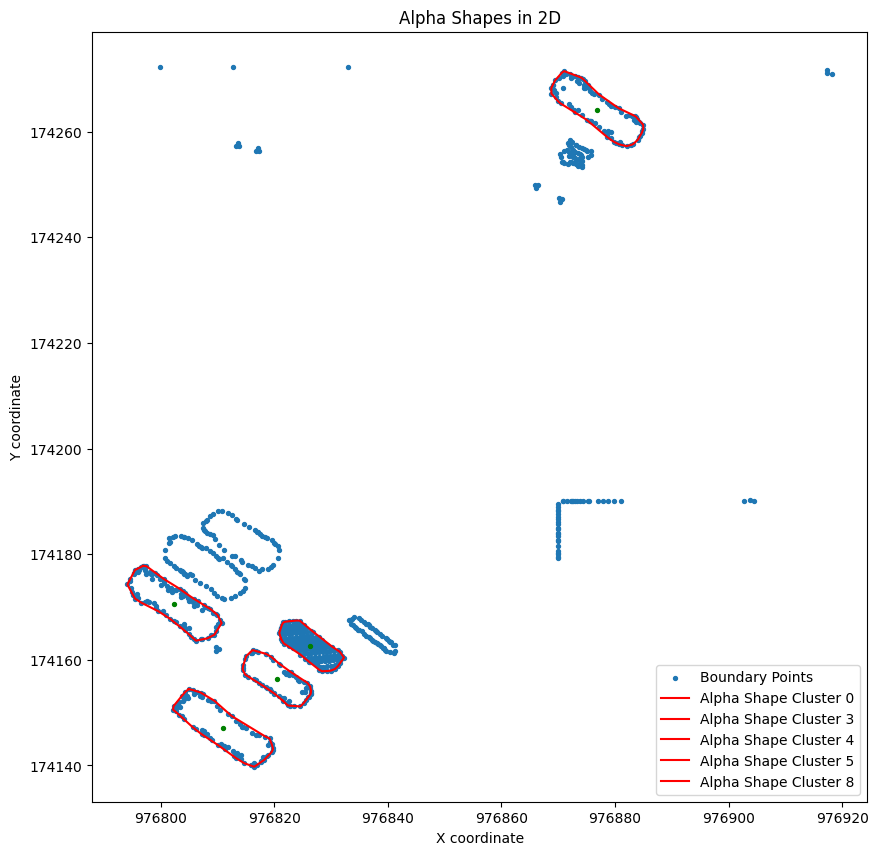

In [98]:
# Visualize the alpha shapes
plt.figure(figsize=(10, 10))
plt.scatter(boundary_points[:, 0], boundary_points[:, 1], label='Boundary Points', s=8)

for label, shapes in alpha_shapes.items():
    for shape in shapes:
        shape = np.array(shape)
        plt.plot(shape[:, 0], shape[:, 1], label=f'Alpha Shape Cluster {label}', color='red')
        poly = Polygon(shape)
        cent = poly.centroid
        plt.scatter(cent.x, cent.y, c='green',s=8)

plt.legend()
plt.title('Alpha Shapes in 2D')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.show()

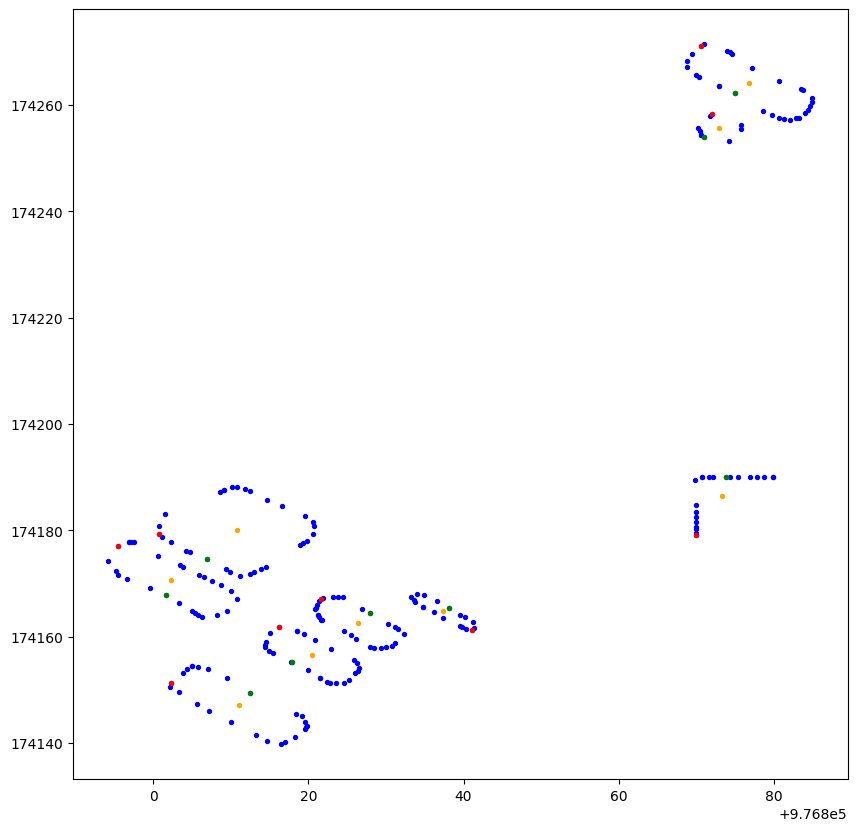

Interested Labels
[0, 44.71951720328736, 18.424308496110243, 5.2695060082918, 'Actual Area: 98.8346999998545', 'calculated area: 97.08700431887458', 'Area Error (%): 1.7683017007007553', 'Width Error (%) : 0.575358334116979', 3.5]
[3, 44.97784143211861, 18.53475112708034, 5.765897446476526, 'Actual Area: 101.75120000002613', 'calculated area: 106.86947419471045', 'Area Error (%): 5.030185584723328', 'Width Error (%) : 8.790517858047659', 3.21]
[4, 46.97004383058031, 19.196013416217408, 5.498571163345452, 'Actual Area: 111.29380000000565', 'calculated area: 105.55064582160546', 'Area Error (%): 5.160354106338267', 'Width Error (%) : 3.7466257234990965', 3.49]
[5, 33.89192580255604, 13.422262761046799, 5.594844536937345, 'Actual Area: 65.19560000007316', 'calculated area: 75.09547348198025', 'Area Error (%): 15.184879780071023', 'Width Error (%) : 5.563104470515954', 2.4]
[8, 31.317620041559675, 12.769937646065722, 4.761006803483499, 'Actual Area: 56.41104999997488', 'calculated area: 60

In [88]:
'''plt.figure(figsize=(10, 10))
#plt.scatter(boundary_points[:, 0], boundary_points[:, 1], label='Boundary Points', s=8)
interested_labels = set([0,3,4,5,8])
interested_labels_ = []
non_interested_labels_ = []
for label, shapes in alpha_shapes.items():
    coords = shapes[0]
    poly = Polygon(coords)
    #print (poly)
    ##min_rot = poly.minimum_rotated_rectangle
    #plt.plot(min_rot[:,0], min_rot[:,1])
    new_coords = np.array(coords)
    cent = np.array([poly.centroid.x, poly.centroid.y])
    dist = []
    min_point, max_point = None, None
    min_dist, max_dist = 1000, -1
    for i in range(len(coords)):
        tempDist = distance(new_coords[i], cent)
        if (min_dist > tempDist):
            min_dist = tempDist
            min_point = np.array(new_coords[i])

        if (max_dist < tempDist):
            max_dist = tempDist
            max_point = np.array(new_coords[i])
        #dist.append()
    # Instead of min_dist, maybe you can consider perpendicular to the plot 
    #min_dist = min(dist)
    #max_dist = max(dist)
    # max_dist is mostly going to be a hypotenuse. So we cannot consider it as a length. Or maybe we can have a buffer 
    # error from length value to hypotenuse value to correct for corrections.
    l = 2 * np.sqrt(max_dist**2 - np.divide(min_dist**2, 4))
    calculated_area = 2*min_dist * l
    other_area = 2*min_dist * 2 * max_dist
    width = 2 * min_dist
    car_width = 5.3 # Calculate in Cloud compare and put an average value here.
    car_aspect_ratio = 1.6 # Calculate set of aspect ratios and finalize a constant or threshold for that
    error_percent_area = (abs(calculated_area - poly.area)/poly.area)*100
    error_percent_width = (abs(width-car_width)/ car_width)*100
    aspect_ratio = round(l / width, 2)

    # So we can eliminate the noise by following a set of conditions
    # 1) Check the width error of the car. If its below 15% (can be modified) then it qualifies to go to the next constraint
    # 2) Check if it qualifies the threshold aspect ratio (1.6)
    # 3) Check the area error of the car. If its below 15% (can be modified. Need to find a suitable considering perfect shapes and ideal conditions to get more accurate results) then it is not noise and could possible be a car.

    if (label in interested_labels):
        interested_labels_.append([label, poly.length, l, width, "Actual Area: " + str(poly.area), "calculated area: " + str(calculated_area), "Area Error (%): " + str(error_percent_area), "Width Error (%) : "+ str(error_percent_width), aspect_ratio])
    else:
        non_interested_labels_.append([label, poly.length, l, width, "Actual Area: " + str(poly.area),  "calculated area: " + str(calculated_area), "Area Error (%): " + str(error_percent_area), "Width Error (%) : "+ str(error_percent_width), aspect_ratio])
    
    plt.scatter(new_coords[:,0], new_coords[:,1], c='blue', s=8)
    plt.scatter(cent[0], cent[1], c='orange', s=8)
    plt.scatter(min_point[0], min_point[1], c='green', s=8)
    plt.scatter(max_point[0], max_point[1], c='red', s=8)

plt.show()
print ("Interested Labels")
for i in interested_labels_:
    print (i)

print ("Non-interested labels")
for i in non_interested_labels_:
    print (i)'''

In [99]:

# Load alpha shapes from JSON file
with open('alpha_shapes_new.json', 'r') as f:
    alpha_shapes = json.load(f)

In [100]:
# Load the 3D dataset from a LAS file
las_file_path = 'sunset pk g lot smalldata.las'
las = laspy.read(las_file_path)
three_d_points = np.vstack([las.x, las.y, las.z]).transpose()

In [101]:
three_d_points

array([[9.76904690e+05, 1.74272287e+05, 8.92800000e+00],
       [9.76906548e+05, 1.74272136e+05, 8.98200000e+00],
       [9.76907413e+05, 1.74272065e+05, 9.00900000e+00],
       ...,
       [9.76918674e+05, 1.74196009e+05, 9.31400000e+00],
       [9.76919079e+05, 1.74196764e+05, 9.38100000e+00],
       [9.76918916e+05, 1.74195011e+05, 9.30700000e+00]])

In [102]:
len(alpha_shapes)

5

In [104]:
from scipy.spatial import cKDTree
# Function to check if a 3D point is within a 2D polygon
def is_point_in_polygon(point, polygon):
    p = Point(point[0], point[1])
    return polygon.contains(p)

In [109]:
point_labels = []
labels = []

# Define the cKDTree beforehand instead of recomputing all the time.
ckdTree = cKDTree(points_2d)

for label, shapes in alpha_shapes.items():
    print(f"Processing label: {label}")
    for shape in shapes:
        shape_coords = [tuple(coord) for coord in shape]  # Ensure coordinates are tuples
        '''
        print(f"Shape: {shape_coords}")
        try:
            polygon = Polygon(shape_coords)
        except TypeError as e:
            print(f"Error processing shape {shape_coords}: {e}")
            continue
        '''

        neighboring_points = []
        for i in range(len(shape)):
            # We use 1 as a buffer value to accomodate more points while for extraction of the vehicle
            tempPoints = ckdTree.query_ball_point(shape[i], 0.25)
            neighboring_points.extend(tempPoints)
        neighboring_points = np.unique(neighboring_points)
        print (len(neighboring_points))
        
        new_points = np.vstack([shape, points_2d[neighboring_points]])
        new_shape = alphashape.alphashape(new_points, 0.05)
        
        # Debug: count the points that fall within each polygon
        count = 0
        points_within_alpha_shape = []
        print ("Collecting points for label of interest")
        for point in three_d_points:
            if is_point_in_polygon(point, new_shape):
                points_within_alpha_shape.append(point)
                count += 1
        print(f"Points within this shape: {count}")

    points_within_alpha_shape = np.array(points_within_alpha_shape)
    if (len(points_within_alpha_shape) > 0):
        point_labels.append(points_within_alpha_shape)
        labels.append(label)


Processing label: 0
86
Points within this shape: 5483
Processing label: 3
79
Points within this shape: 5353
Processing label: 4
75
Points within this shape: 5988
Processing label: 5
84
Points within this shape: 3186
Processing label: 8
84
Points within this shape: 3149


In [110]:
# Save points within alpha shapes to a new LAS file
for i, label in enumerate(labels):
    if len(point_labels[i]) > 0:
        header = laspy.LasHeader(point_format=las.header.point_format, version=las.header.version)
        new_las = laspy.LasData(header)
        points_within_alpha_shape = point_labels[i]
        new_las.x = points_within_alpha_shape[:, 0]
        new_las.y = points_within_alpha_shape[:, 1]
        new_las.z = points_within_alpha_shape[:, 2]

        output_file_path = 'points_within_alpha_shape_new'+label+'.las'
        new_las.write(output_file_path)

        print(f"Saved points within alpha shapes to '{output_file_path}'")

Saved points within alpha shapes to 'points_within_alpha_shape_new0.las'
Saved points within alpha shapes to 'points_within_alpha_shape_new3.las'
Saved points within alpha shapes to 'points_within_alpha_shape_new4.las'
Saved points within alpha shapes to 'points_within_alpha_shape_new5.las'
Saved points within alpha shapes to 'points_within_alpha_shape_new8.las'
